In [1]:
%cd ../

/atlas2/u/haotiany/chempath/OAPathDiff


In [2]:
import pymol
from pymol import cmd, stored
import imageio

import os
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


In [3]:
# --- Importing and defining some functions ----
import torch
import py3Dmol
import numpy as np

from typing import Optional
from torch import tensor
from e3nn import o3
from torch_scatter import scatter_mean

from oa_reactdiff.model import LEFTNet

default_float = torch.float64
torch.set_default_dtype(default_float)  # Use double precision for more accurate testing

def map_num_to_ele(atom_lis: list):
    map_dict = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F'}
    return [map_dict[atom] for atom in atom_lis]


def remove_mean_batch(
    x: tensor, 
    indices: Optional[tensor] = None
) -> tensor:
    """Remove the mean from each batch in x

    Args:
        x (tensor): input tensor.
        indices (Optional[tensor], optional): batch indices. Defaults to None.

    Returns:
        tensor: output tensor with batch mean as 0.
    """
    if indices == None:
         return x - torch.mean(x, dim=0)
    mean = scatter_mean(x, indices, dim=0)
    x = x - mean[indices]
    return x


def draw_in_3dmol(mol: str, fmt: str = "xyz") -> py3Dmol.view:
    """Draw the molecule

    Args:
        mol (str): str content of molecule.
        fmt (str, optional): format. Defaults to "xyz".

    Returns:
        py3Dmol.view: output viewer
    """
    viewer = py3Dmol.view(1024, 576)
    viewer.addModel(mol, fmt)
    viewer.setStyle({'stick': {}, "sphere": {"radius": 0.36}})
    viewer.zoomTo()
    return viewer


def assemble_xyz(z: list, pos: tensor) -> str:
    """Assembling atomic numbers and positions into xyz format

    Args:
        z (list): chemical elements
        pos (tensor): 3D coordinates

    Returns:
        str: xyz string
    """
    natoms =len(z)
    xyz = f"{natoms}\n\n"
    for _z, _pos in zip(z, pos):
        xyz += f"{_z}\t" + "\t".join([str(x) for x in _pos]) + "\n"
    return xyz

from scipy.linalg import svd

def calculate_rmsd(A, B, allow_change = True):
    # 质心计算
    if not allow_change:
        return np.sqrt(np.mean(np.linalg.norm(A - B, axis=1) ** 2))
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # 中心化坐标
    A_centered = A - centroid_A
    B_centered = B - centroid_B
    
    # 构造协方差矩阵
    H = np.dot(A_centered.T, B_centered)
    
    # SVD 分解
    U, S, Vt = svd(H)
    
    # 计算旋转矩阵
    d = (np.linalg.det(U) * np.linalg.det(Vt)) < 0.0
    if d:
        S[-1] = -S[-1]
        U[:, -1] = -U[:, -1]
    rotation_matrix = np.dot(Vt.T, U.T)
    
    # 应用旋转
    A_rotated = np.dot(A_centered, rotation_matrix)
    
    # 计算 RMSD
    rmsd = np.sqrt(np.mean(np.linalg.norm(A_rotated - B_centered, axis=1) ** 2))
    return rmsd

In [4]:


# dataset = np.load('oa_reactdiff/data/path/ts1x_rxn_neb_structures.pkl', allow_pickle=True)
dataset = np.load('oa_reactdiff/data/path/path_structures.pkl', allow_pickle=True).item()
len(dataset),dataset['rxn0000'][0].keys()


(10073,
 dict_keys(['rxn', 'wB97x_6-31G(d).energy', 'wB97x_6-31G(d).atomization_energy', 'wB97x_6-31G(d).forces', 'positions', 'formula', 'atomic_numbers']))

In [5]:
def save_img(mol: str, file_name: str):
    # save the molecule to a file

    with open(f"{file_name}.xyz", 'w') as f:
        f.write(mol)
        

    cmd.reinitialize()
    # load the xyz file into pymol
    cmd.load(f"{file_name}.xyz", 'molecule')

    
    cmd.hide('everything', 'molecule')
    cmd.show('spheres', 'molecule')  # Display as cartoon
    cmd.show('sticks', 'molecule')  # Display as cartoon

    cmd.set('stick_radius', 0.1)  # Adjust the radius of the sticks
    cmd.set('sphere_scale', 0.15)   # Adjust the size of the spheres
    cmd.png(f"{file_name}.png")

    # delete the xyz file
    os.remove(f"{file_name}.xyz")

In [6]:
formula = [w[0]['formula'] for w in dataset.values()]

# count unique string in formula and their appearance
molecules, counts = np.unique(formula, return_counts=True)
num_molecules = {molecule: count for molecule, count in zip(molecules, counts)}

molecules.shape, counts.mean(), counts.max(), counts.min()

((171,), 58.90643274853801, 447, 1)

In [7]:
# understand atom types
sets = [set(w[0]['atomic_numbers']) for w in dataset.values()]

# union of all atom types
all_atom_types = set.union(*sets)
all_atom_types

{1, 6, 7, 8}

(4, 23, 13.052631578947368)

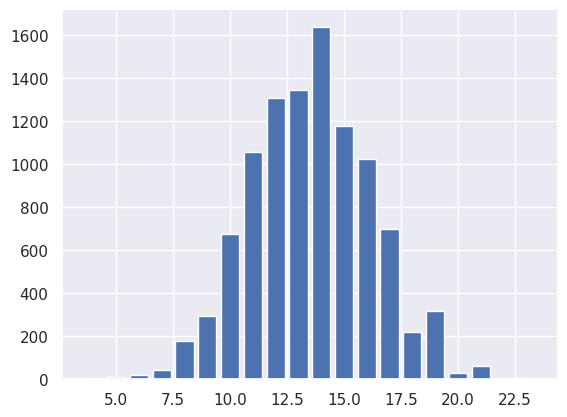

In [8]:
num_atom_lis = [len(w[0]['atomic_numbers']) for w in dataset.values()]
ks, vs = np.unique(num_atom_lis, return_counts=True)
num_atoms = {k: v for k, v in zip(ks, vs)}
plt.bar(num_atoms.keys(), num_atoms.values())
ks.min(), ks.max(), ks.mean()

In [46]:
idx = np.argmax(num_atom_lis)
print(idx, num_atom_lis[idx], list(dataset.keys())[idx])
# find the molecule with the most atoms
# frame = dataset['rxn8742'][1]
frame = dataset['rxn10070'][0]   # 0006 is a very smooth example
# 10071 is great as well
pos = frame['positions']

# map atomic_number to element
atomic_number = frame['atomic_numbers']

tmp = assemble_xyz(map_num_to_ele(frame['atomic_numbers']), pos)
a = draw_in_3dmol(tmp)
a.show()

10026 23 rxn8742


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
name = 'rxn10071'
traj = dataset[name]
os.makedirs(f'temp_images/{name}', exist_ok=True)
for i in range(10):
    frame = traj[i]
    tmp = assemble_xyz(map_num_to_ele(frame['atomic_numbers']), frame['positions'])
    save_img(tmp, f'temp_images/{name}/{i}')

# --- Generate a gif ---
images = [imageio.imread(f'temp_images/{name}/{i}.png') for i in range(10)]
imageio.mimsave(f'temp_images/traj_{name}.gif', images, duration=5, loop=0)

import time
time.sleep(0.01)
# delete all png files
[os.remove(f'temp_images/{name}/{i}.png') for i in range(10)]
os.removedirs(f'temp_images/{name}')

/tmp/user/23218/ipykernel_2167240/3899373666.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'temp_images/{name}/{i}.png') for i in range(10)]


<Axes: >

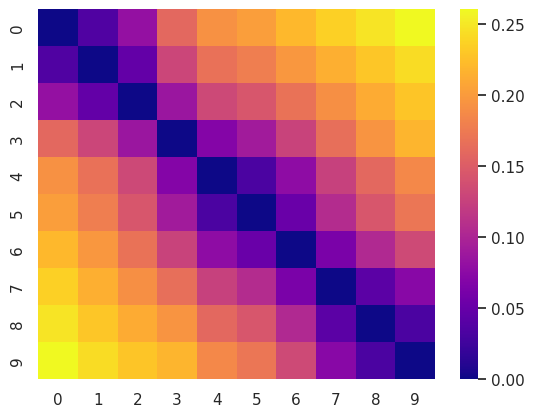

In [33]:
# find the minimum distance between two molecules under possible rotations and translations

name = 'rxn8742'

def min_rmsd(a, b, allow_change = True):
    if not allow_change:
        return np.sum((a - b) ** 2)/a.shape[0]
    return scipy.spatial.transform.Rotation.align_vectors(a, b)[1]/a.shape[0]

# draw a heat map representing the rmsd between frames 0 to 9
mat_false, mat_true = np.zeros((10, 10)), np.zeros((10, 10))
mats = []
for i in range(0, 10000, 10):
    name = f'rxn{i:04d}'
    mat = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            mat_true[i, j] = min_rmsd(dataset[name][i]['positions'], dataset[name][j]['positions'])
            # mat_false[i, j] = min_rmsd(dataset[name][i]['positions'], dataset[name][j]['positions'], allow_change=False)
    mats.append(mat_true)
mat_true = np.mean(mats, axis=0)

# print(mat_false)
# print(mat_true)
# print(mat_false - mat_true)

# show the heat map using seaborn
sns.heatmap(mat_true, cmap='plasma')


In [25]:
energies = [[frame['wB97x_6-31G(d).energy'] for frame in traj] for traj in dataset.values()]
# plt.plot([frame['wB97x_6-31G(d).atomization_energy'] for frame in traj])
# plt.plot([frame['wB97x_6-31G(d).energy'] for frame in traj])
energies = np.array(energies)

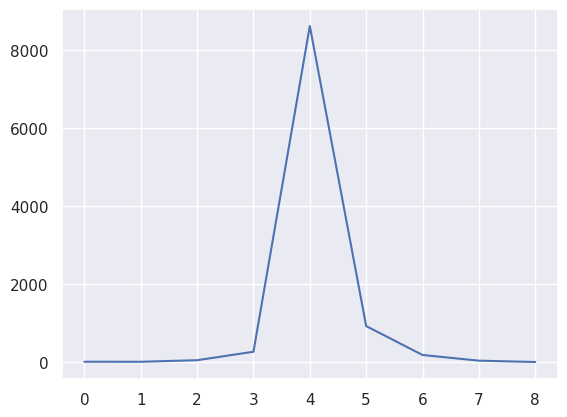

In [29]:
plt.plot(np.unique(energies.argmax(axis=1), return_counts=True)[1])

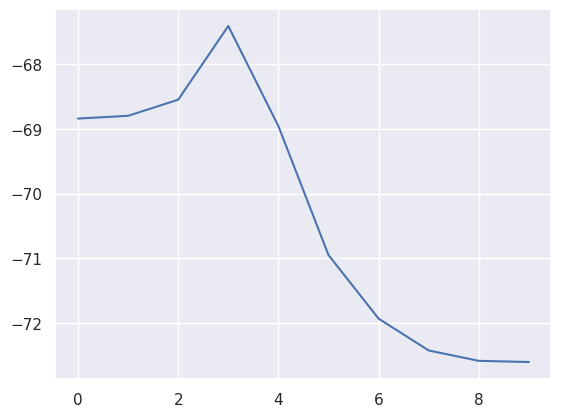

In [30]:
traj = dataset['rxn10000']

plt.plot([frame['wB97x_6-31G(d).atomization_energy'] for frame in traj])
